In [104]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import torch
import torchvision
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
from torchvision.datasets import ImageFolder

import torch.nn as nn
import torch.nn.functional as F

# # for imbalanced dataset
# from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.utils import save_image
from random import randint

In [132]:
data_path = '../anime-faces/data/'
transform = transforms.Compose(
    [
        transforms.Resize((64,64)), # resize images to same size
        torchvision.transforms.ToTensor(), # image to tensor
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # mean=[.5,.5,.5],std=[.5,.5,.5]
    ]
)

# dataset
dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)

# train test split
num_data = len(dataset)
ratio = .9
# print(num_data)
# print(int(num_data*0.8), num_data-int(num_data*0.8))
trainSet, testSet = torch.utils.data.random_split(dataset, [int(num_data*ratio), num_data-int(num_data*ratio)])
print("number of train data:", len(trainSet))
print("number of test data:", len(testSet))

# dataloader
trainLoader = torch.utils.data.DataLoader(
    trainSet,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)
testLoader = torch.utils.data.DataLoader(
    testSet,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)
# print(train_loader.dataset)


number of train data: 19395
number of test data: 2156


In [131]:
'''
印出設定
'''
def printARGS():
    epochs = 15
    batch_size = 32# num_workers = 2   # num_workers
    latent_code = 32   
    save_interval = 50
    batch = len(trainSet) / batch_size
    image_size = int(64 * 64 * 3)

    print("Epochs: ", epochs)
    print("Batch size: ", batch_size)
    print("Latent code: ", latent_code)
    print("Save log interval: ", save_interval)
    print("Batch nums: ", batch)
    print("Image size: ", image_size)

printARGS()


Epochs:  15
Batch size:  32
Latent code:  32
Save log interval:  50
Batch nums:  606.09375
Image size:  12288


In [124]:
# '''
# 試著印出圖片
# 並確認圖片大小
# '''
# from matplotlib.pyplot import imshow
# import numpy as np
# from PIL import Image
# import glob

# # %matplotlib inline

# image_list = []
# image_size = []
# for filename in glob.glob('../anime-faces/data/*.png'):
#     img = Image.open(filename)
#     image_list.append(img)
#     image_size.append(img.size)
#     img.load()
# # img = Image.open('../anime-faces/data/1.png', 'r')
# # imshow(np.asarray(img))
# # print(img.size)
# def unique(list1):
#     unique_list = []
#     for x in list1:
#         if x not in unique_list: 
#             unique_list.append(x)
#     for x in unique_list: 
#         print(x)
# unique(image_size) # size 皆是 64*64

(64, 64)


In [70]:
'''
公式如下: 
new_height = new_width = (W — F + 1) / S （结果向上取整數，假設算出來結果是4.5，取5）
(原本 - filter + 1) / stride

例子
filter 3x3, stride=1, 卷積後的大小: (10–3+1)/1=8
filter 3x3, stride=2, 卷積後的大小: (10–3+1)/2=4
'''

'\n公式如下: \nnew_height = new_width = (W — F + 1) / S （结果向上取整數，假設算出來結果是4.5，取5）\n(原本 - filter + 1) / stride\n\n例子\nfilter 3x3, stride=1, 卷積後的大小: (10–3+1)/1=8\nfilter 3x3, stride=2, 卷積後的大小: (10–3+1)/2=4\n'

In [166]:
# CNN VAE
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            Flatten()
        )
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [175]:
vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
'''
loss function
'''
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD
'''
model summary
'''
from torchvision import models
from torchsummary import summary
summary(vae, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 31, 31]           1,568
       BatchNorm2d-2           [-1, 32, 31, 31]              64
              ReLU-3           [-1, 32, 31, 31]               0
            Conv2d-4           [-1, 64, 14, 14]          32,832
       BatchNorm2d-5           [-1, 64, 14, 14]             128
              ReLU-6           [-1, 64, 14, 14]               0
            Conv2d-7            [-1, 128, 6, 6]         131,200
       BatchNorm2d-8            [-1, 128, 6, 6]             256
              ReLU-9            [-1, 128, 6, 6]               0
           Conv2d-10            [-1, 256, 2, 2]         524,544
      BatchNorm2d-11            [-1, 256, 2, 2]             512
             ReLU-12            [-1, 256, 2, 2]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                   

In [174]:
def compare(x):
    recon_x, _, _ = vae(x/255.)
    return torch.cat([x, recon_x/255.])

In [176]:
epochs = 50
loss_record = []
for epoch in range(epochs):
    train_loss = 0
    test_loss = 0

    # for training...
    for idx, (images, _) in enumerate(trainLoader):
        images = images/255. # normalize
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss

        if idx % save_interval == 0:
            to_print = "Epoch[{}/{}] Loss: {:.3f} BCE: {:.3f} KL: {:.3f}".format(epoch+1, epochs, loss.item()/batch_size, bce.item()/batch_size, kld.item()/batch_size)
            print(to_print)
            # sample = Variable(torch.randn(1024, 32))
            # print(vae.fc2(sample).shape)
            # sample = vae.decoder(vae.fc2(sample).view(32, 256, 2, 2))
            # save_image(sample.data.view(32, 3, 64, 64), './result/Sample_' + str(epoch) + '.png')
    
    loss_record.append(train_loss)
    to_print = "Epoch[{}/{}] Training Loss: {:.3f}".format(epoch+1,epochs, train_loss/len(trainSet))
    print(to_print)
    
    # for testing... 
    for idx, (images, _) in enumerate(testLoader):
        images = images/255. # normalize
        recon_images, mu, logvar = vae(images)
        loss, _, _ = loss_fn(recon_images, images, mu, logvar)
        test_loss += loss
    
    to_print = "Epoch[{}/{}] Testing Loss: {:.3f}".format(epoch+1,epochs, test_loss/len(testSet))
    print(to_print)
    
    # when epoch finishing...
    img = testSet[randint(1, 100)][0].unsqueeze(0)
    compare_img = compare(img)*255
    save_image(compare_img.data, 'sample_image.png')
    # display(Image('sample_image.png',width=700, unconfined=True))    


462 BCE: 201.400 KL: 0.062
Epoch[38/50] Loss: 212.408 BCE: 212.347 KL: 0.061
Epoch[38/50] Loss: 206.483 BCE: 206.422 KL: 0.060
Epoch[38/50] Loss: 205.170 BCE: 205.108 KL: 0.062
Epoch[38/50] Loss: 209.110 BCE: 209.047 KL: 0.064
Epoch[38/50] Loss: 208.812 BCE: 208.751 KL: 0.062
Epoch[38/50] Loss: 210.779 BCE: 210.719 KL: 0.061
Epoch[38/50] Loss: 210.124 BCE: 210.062 KL: 0.061
Epoch[38/50] Loss: 211.719 BCE: 211.659 KL: 0.060
Epoch[38/50] Loss: 207.933 BCE: 207.872 KL: 0.061
Epoch[38/50] Training Loss: 210.781
Epoch[38/50] Testing Loss: 211.802
Epoch[39/50] Loss: 213.336 BCE: 213.273 KL: 0.062
Epoch[39/50] Loss: 208.070 BCE: 208.008 KL: 0.062
Epoch[39/50] Loss: 211.888 BCE: 211.826 KL: 0.062
Epoch[39/50] Loss: 208.416 BCE: 208.356 KL: 0.060
Epoch[39/50] Loss: 213.511 BCE: 213.449 KL: 0.061
Epoch[39/50] Loss: 209.251 BCE: 209.189 KL: 0.061
Epoch[39/50] Loss: 206.539 BCE: 206.477 KL: 0.062
Epoch[39/50] Loss: 216.532 BCE: 216.472 KL: 0.060
Epoch[39/50] Loss: 212.686 BCE: 212.625 KL: 0.061
Ep

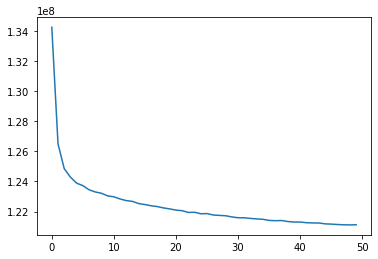

In [170]:
plt.plot(loss_record)

In [ ]:
'''
fc version
'''

In [146]:
# fc VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # self.fc1 = nn.Linear(64*64*3, 400)
        # self.fc2_1 = nn.Linear(400,20)
        # self.fc2_2 = nn.Linear(400,20)
        # self.fc3 = nn.Linear(20,400)
        # self.fc4 = nn.Linear(400,64*64*3)
        self.fc1 = nn.Linear(64*64*3, 1000)
        self.fc2_1 = nn.Linear(1000,50)
        self.fc2_2 = nn.Linear(1000,50)
        self.fc3 = nn.Linear(50,1000)
        self.fc4 = nn.Linear(1000,64*64*3)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2_1(h1), self.fc2_2(h1) # mu and var
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 64*64*3))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    # Reconstruction + KL divergence losses summed over all elements and batch
def loss_func(recon_x, x, mu, logvar):
    bce_loss = F.binary_cross_entropy(recon_x, x.view(-1, 64*64*3), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce_loss+kl_divergence
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

from torchvision import models
from torchsummary import summary

summary(vae, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]      12,289,000
            Linear-2                   [-1, 50]          50,050
            Linear-3                   [-1, 50]          50,050
            Linear-4                 [-1, 1000]          51,000
            Linear-5                [-1, 12288]      12,300,288
Total params: 24,740,388
Trainable params: 24,740,388
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.11
Params size (MB): 94.38
Estimated Total Size (MB): 94.53
----------------------------------------------------------------


In [34]:
# 2 fc
def train(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_func(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        # if batch_idx % save_interval == 0:
        #      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader),
        #         loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
def test(epoch):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [83]:
# from torchvision import models
# from torchsummary import summary

# # vgg = models.vgg16()
# summary(vae, (3, 64, 64))

In [82]:
# for epoch in range(1, epochs + 1):
#     train(epoch)

In [55]:
# # 1 cnn
# for epoch in range(epochs):
#     # vae.train()
#     epoch_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader, 0):
#         #train network
#         data = Variable(data)
#         print(data.shape)
#         optimizer.zero_grad()
#         recon_x, mu, logvar = vae.forward(data)
#         loss = loss_func(recon_x, data, mu, logvar)
#         loss.backward()
#         total_loss += loss#.data[0]
#         optimizer.step()

#         if batch_idx % log_interval == 0:
#             sample = Variable(torch.randn(64, latent_code))
#             sample = vae.decoder(vae.fc2(sample).view(64, 128, 7, 7))
#             save_image(sample.data.view(64, 1, 28, 28),'./result/mysample_' + str(epoch) + '.png')
#             print('Train Epoch:{} -- [{}/{} ({:.0f}%)] -- Loss:{:.6f}'.format(epoch, i*len(data), len(train_loader.dataset), 100.*i/len(train_loader), loss/len(data)))
#             print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, total_loss / len(train_loader.dataset)))

